In [39]:
import getpass, random, sys, time
import numpy as np
import torch
from torchvision.transforms import *

sys.path.append('../..')
from DL.utils import *
from DL.networks import *
from DL.sqlite_data_loader import SQLDataLoader
from Database.DB_models import *

import matplotlib.pyplot as plt
%matplotlib inline

In [61]:
EMBEDDING_MODEL = '/home/lynx/pretrainedmodels/embedding_triplet_resnet50_1499/triplet_resnet50_1499.tar'
CROP_DIR = '/datadrive/missouricameratraps/crops_detector/'
DB_LIMIT = 100

In [62]:
DB_NAME = getpass.getpass('Enter database name:')
DB_USER = getpass.getpass('Enter username for database:')
DB_PASSWORD = getpass.getpass('Enter password for database user:')

Enter database name:········
Enter username for database:········
Enter password for database user:········


In [63]:
target_db = PostgresqlDatabase(DB_NAME, user=DB_USER, password=DB_PASSWORD, host='localhost')
target_db.connect(reuse_if_open=True)
db_proxy.initialize(target_db)
dataset_query = Detection.select(Detection.image_id, Oracle.label, Detection.kind).join(Oracle).limit(DB_LIMIT)
dataset = SQLDataLoader(CROP_DIR, query=dataset_query, is_training=False, kind=DetectionKind.ModelDetection.value, num_workers=8, limit=DB_LIMIT)
sample_ids = [s[0] for s in dataset.samples]

Reading database to get samples.
[0, 100, 0, 0, 0]
Load dataset mean and std from database


In [64]:
checkpoint = load_checkpoint(EMBEDDING_MODEL)
if checkpoint['loss_type'].lower() == 'center' or checkpoint['loss_type'].lower() == 'softmax':
    embedding_net = SoftmaxNet(checkpoint['arch'], checkpoint['feat_dim'], False)
else:
    embedding_net = NormalizedEmbeddingNet(checkpoint['arch'], checkpoint['feat_dim'], False)
model = torch.nn.DataParallel(embedding_net).cuda()
model.load_state_dict(checkpoint['state_dict'])
model.eval()


DataParallel(
  (module): NormalizedEmbeddingNet(
    (inner_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (re

In [65]:
model_inner_resnet = list(model.children())[0].inner_model
# model_inner_resnet.eval() # not sure if this is necessary

In [81]:
outputs = []
def hook(module, input, output):
    outputs.append(output)
model_inner_resnet.layer1[0].conv3.register_forward_hook(hook)

torch.Size([3, 224, 224])


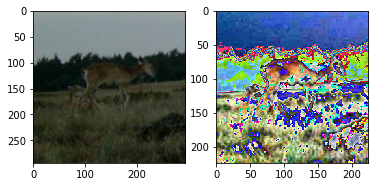

In [82]:
random_sid = random.sample(sample_ids, 1)[0]
dataset.image_mode()
random_img = dataset.loader(random_sid)
random_img_tensor = dataset.eval_transform(random_img)
print(random_img_tensor.shape)
plt.subplot(1,2,1)
plt.imshow(np.asarray(random_img))
plt.subplot(1,2,2)
plt.imshow(np.asarray(ToPILImage()(random_img_tensor)))

In [83]:
output = model.forward(random_img_tensor.unsqueeze(0))
intermediate_output = outputs[0].cpu().detach().numpy()
print(intermediate_output.shape)

(1, 256, 56, 56)


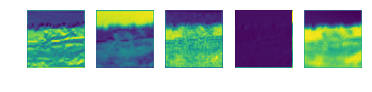

In [84]:
n_channels_to_vis = 5
for i in range(n_channels_to_vis):
    plt.subplot(1,n_channels_to_vis,i+1)
    rand_channel_no = random.sample(range(intermediate_output.shape[1]), 1)[0]
    plt.imshow(intermediate_output[0,rand_channel_no,:,:], cmap='viridis')
    plt.axis('off')